In [1]:
# Import dependencies required to run this code.
%matplotlib notebook
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.ion()

In [ ]:
#Load data set for Iceland
roads = gpd.read_file('Iceland/roads.shp').to_crs(32626)
rivers = gpd.read_file('Iceland/waterways.shp').to_crs(32626)
points = gpd.read_file('Iceland/points.shp').to_crs(32626)
counties = gpd.read_file ('Iceland/ISL_adm1.shp').to_crs(32626)
population = gpd.read_file('Iceland/population.shp').to_crs(32626)
outline = gpd.read_file('Iceland/ISL_adm0.shp').to_crs(32626)

In [2]:
#Set functions to generate figure box handles
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

<IPython.core.display.Javascript object>


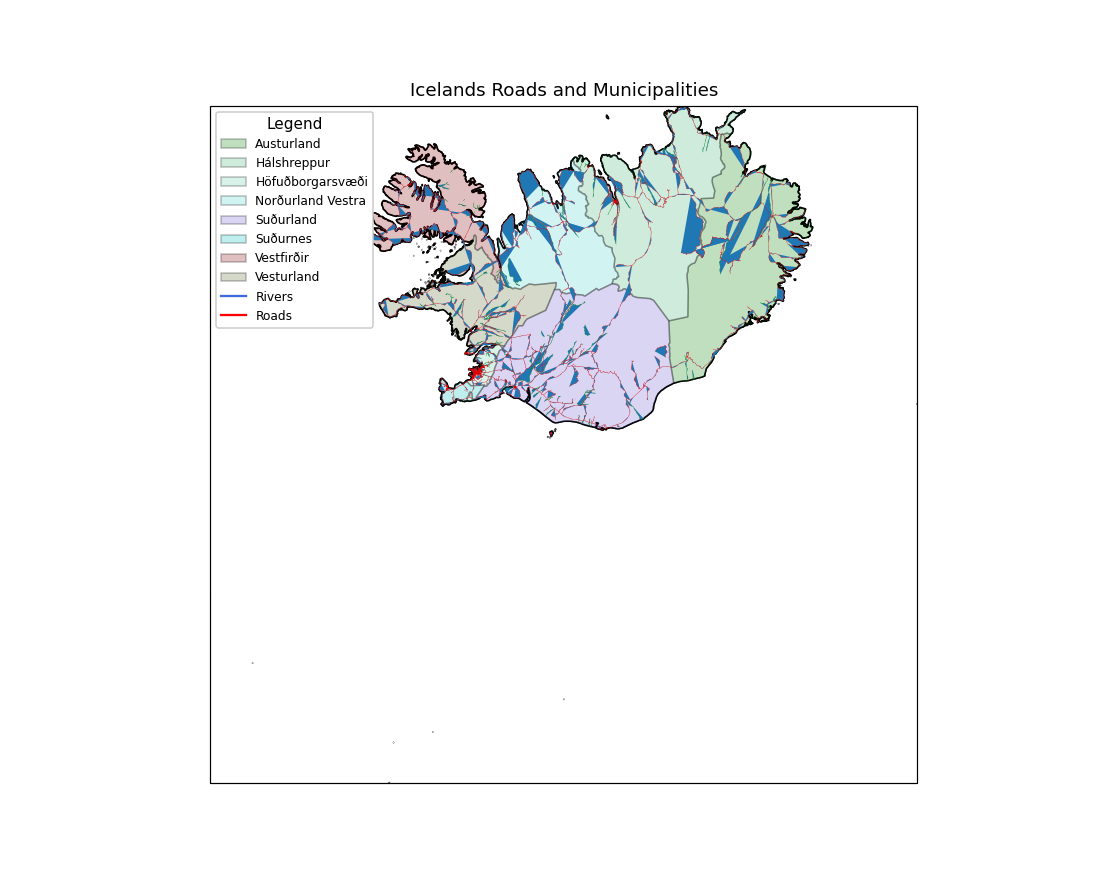

<IPython.core.display.Javascript object>


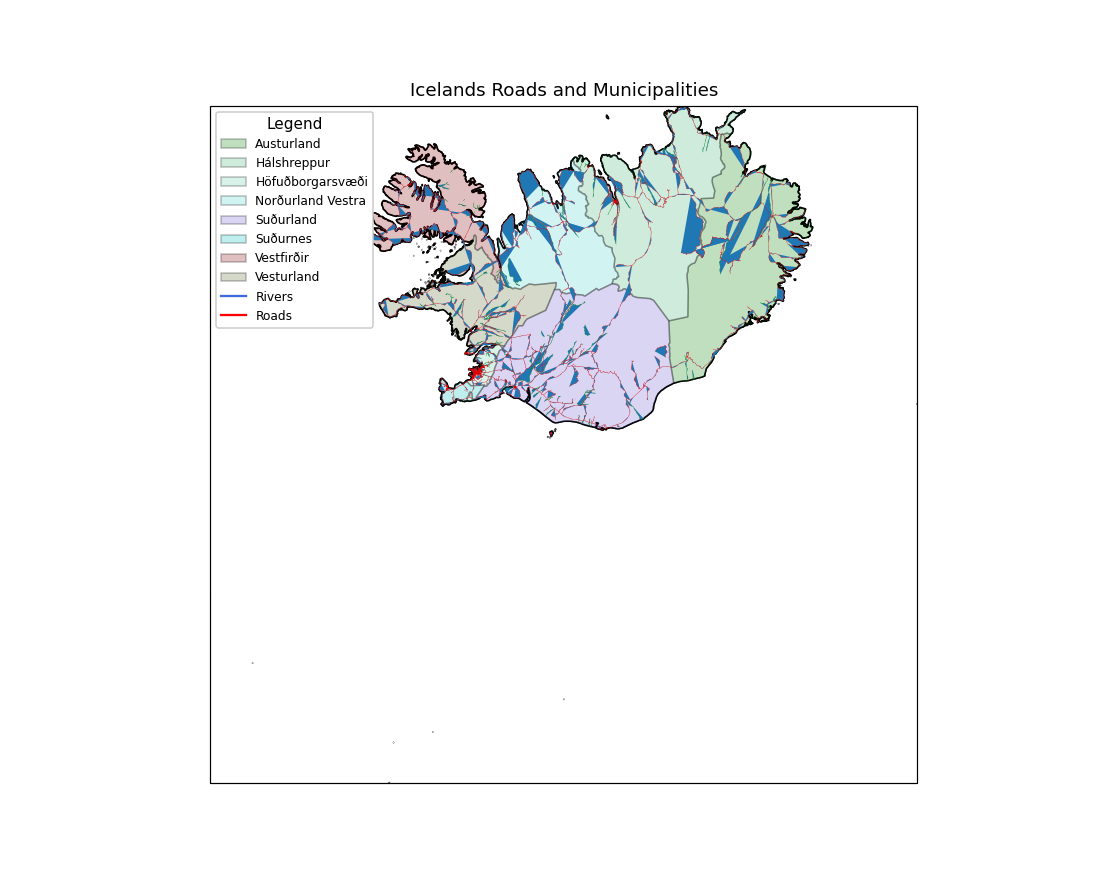

In [4]:
# Set figure outline and Universal Transector Mecrator zone and projections
myFig = plt.figure(figsize=(10,8))

myCRS = ccrs.UTM(26)  

ax = plt.axes(projection=ccrs.UTM(26))

myFig #Shows the loaded data in a figure

<IPython.core.display.Javascript object>


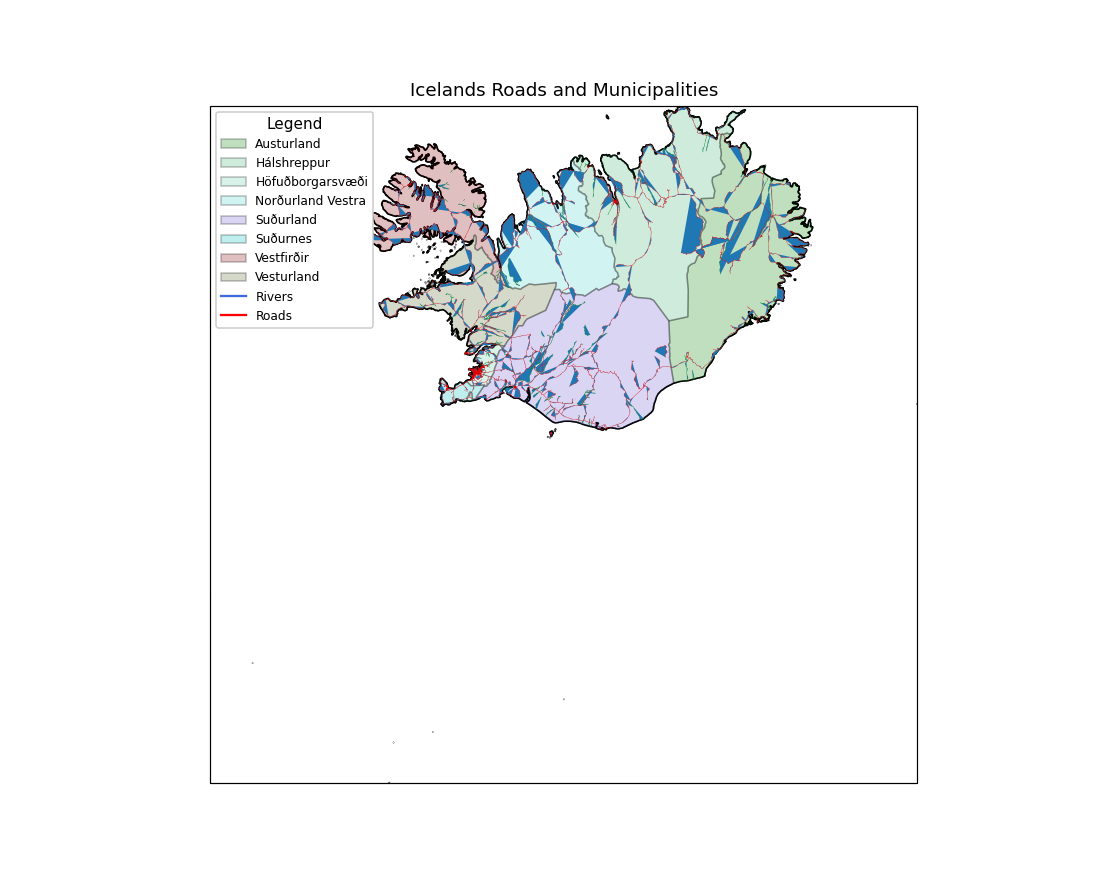

In [5]:
#This sets the outline geometry of the Counties in Iceland (outline_feature)
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = outline.total_bounds
ax.add_feature(outline_feature)

ax.set_extent([xmin, xmax, ymin, ymax], crs=myCRS) #The extent of the axes on the map

myFig

In [6]:
#This investigates the number of unique county values in the dataset (.unique())
num_counties = len(counties.NAME_1.unique())
print('Number of unique features: {}'.format(num_counties))

Number of unique features: 8


In [7]:
#This summerises the dataframe so we an see the Unique county names
df = pd.read_csv('Iceland\ISL_adm1.csv')
df.head()
df

,OBJECTID,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1
0,1,104,ISL,Iceland,1,Austurland,Landsvæði,Region,NaN,Eastland
1,2,104,ISL,Iceland,2,Hálshreppur,Landsvæði,Region,NaN,Norðurland eystra|Northland East
2,3,104,ISL,Iceland,3,Höfuðborgarsvæði,Landsvæði,Region,NaN,Capital|Reykjavik and Reykjane
3,4,104,ISL,Iceland,4,Norðurland vestra,Landsvæði,Region,NaN,Northland West
4,5,104,ISL,Iceland,5,Suðurland,Landsvæði,Region,NaN,Southland|South
5,6,104,ISL,Iceland,6,Suðurnes,Kaupstadir,Independent Town,NaN,Southern Peninsula
6,7,104,ISL,Iceland,7,Vestfirðir,Landsvæði,Region,NaN,Western Fjords|Western Peninsula
7,8,104,ISL,Iceland,8,Vesturland,Landsvæði,Region,NaN,Westland|West


<IPython.core.display.Javascript object>


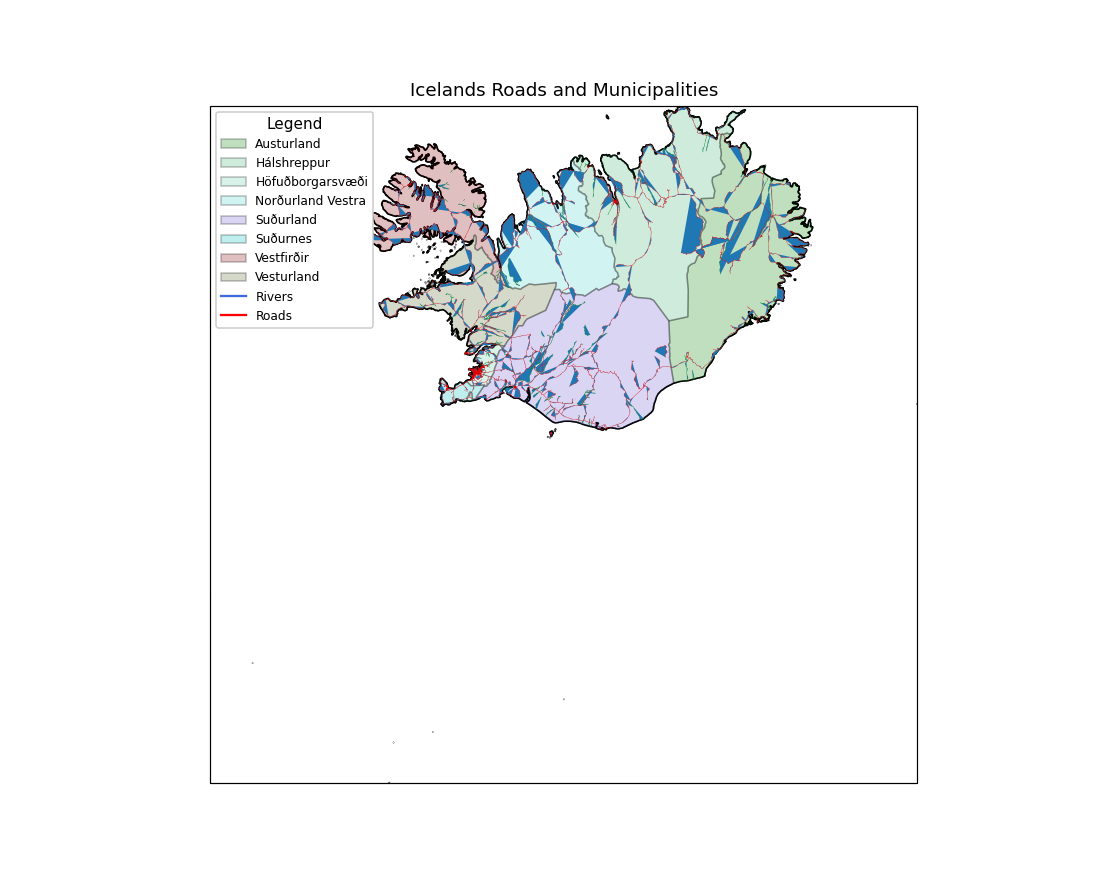

In [8]:
#Colours and boundaries are added to the map by name and location 
county_colors = ['g','mediumseagreen','mediumaquamarine','mediumturquoise','slateblue','c','maroon','darkolivegreen']

county_names = list(counties.NAME_1.unique())
county_names.sort()

for i, name in enumerate(county_names):
    feat = ShapelyFeature(counties['geometry'][counties['NAME_1'] == name], myCRS, 
                          edgecolor='k',
                          facecolor=county_colors[i],
                          linewidth=1,
                          alpha=0.25)
    ax.add_feature(feat)
    
myFig


<IPython.core.display.Javascript object>


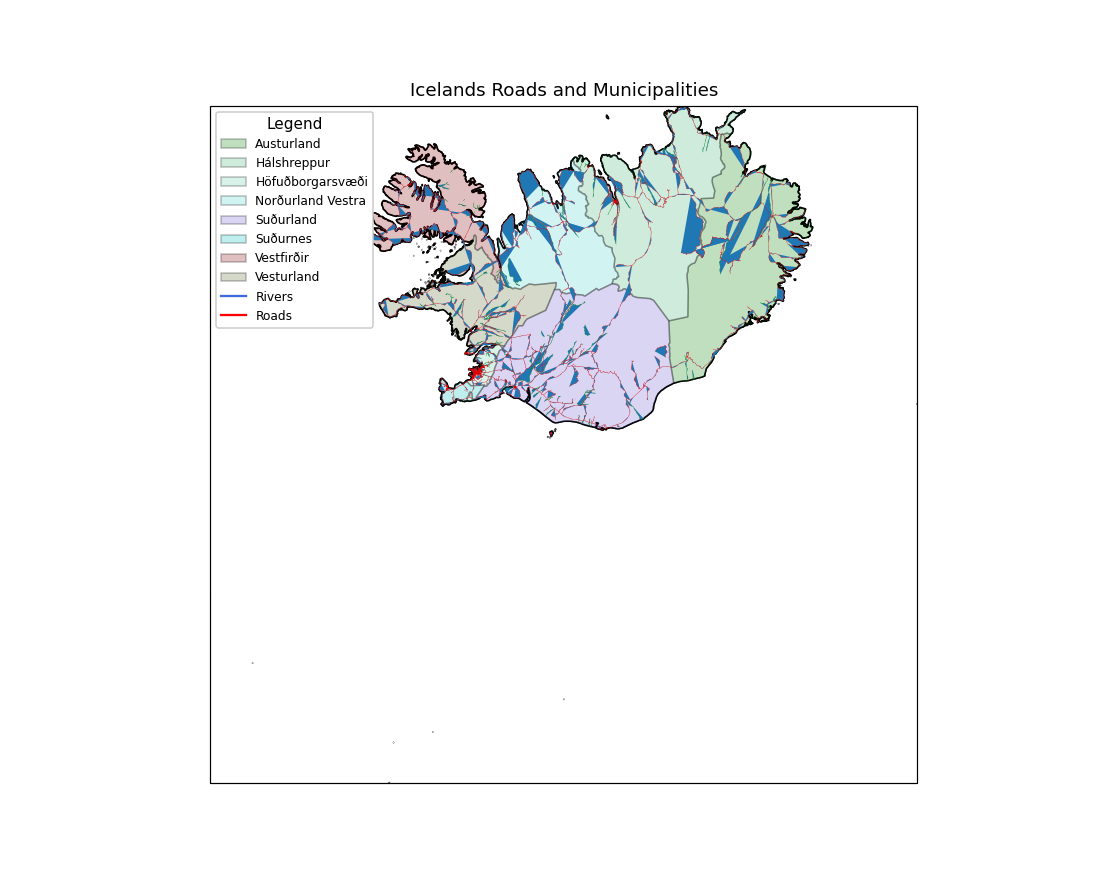

In [9]:
#Features are added using Shapely for rivers and roads. Including line colour and width.
river_feat = ShapelyFeature(rivers['geometry'], myCRS,
                            edgecolor='green',
                            linewidth=0.2)
ax.add_feature(river_feat)
roads_feat= ShapelyFeature(roads['geometry'], myCRS,
                            edgecolor='red',
                             linewidth=0.2)

ax.add_feature(roads_feat)

myFig

<IPython.core.display.Javascript object>


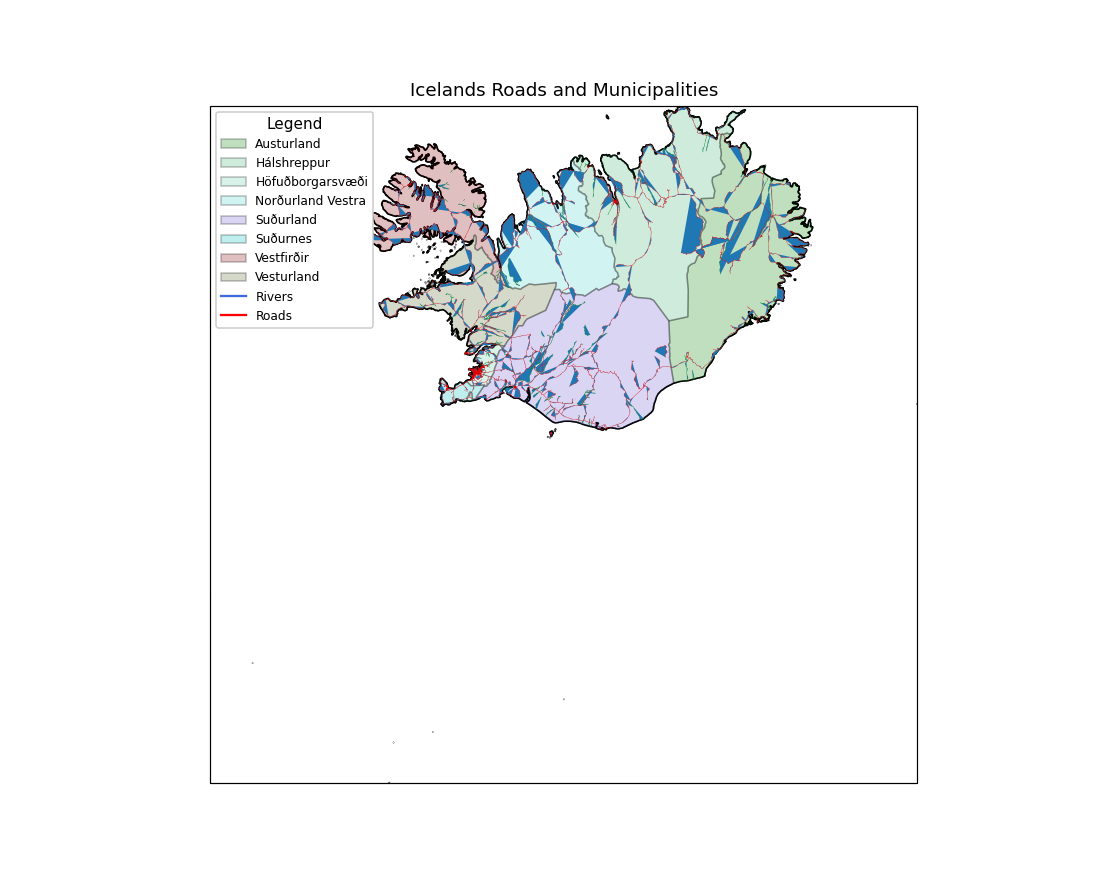

In [10]:
#generate a list of handles for the county datasets
county_handles = generate_handles(counties.NAME_1.unique(), county_colors, alpha=0.25)

river_handle = [mlines.Line2D([], [], color='royalblue')]

roads_handle = [mlines.Line2D([],[], color='red')]

# Update the county name for title capitilisation
nice_names = [name.title() for name in county_names]

# Make a legend listing the feautures, county names, rivers and roads(ax.legend())
handles = county_handles + river_handle + roads_handle

labels = nice_names + ['Rivers', 'Roads']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=10, 
                 fontsize=8, loc='upper left', frameon=True, framealpha=1)
#Add a map title
ax.set(title='Icelands Roads and Municipalities')

myFig

In [ ]:
#Add gridlines to the map 
gridlines = ax.gridlines(draw_labels=True,
                         xlocs=[-26,-24,-22,-20,-18,-16,-14,-12], 
                         ylocs=[66,65,64,63,62,61])
gridlines.left_labels = False # turn off the left-side labels
gridlines.bottom_labels = False # turn off the bottom labels
ax.set_extent([xmin, xmax, ymin, ymax], crs=myCRS)

---------------------------------------------------- Section 2 -------------------------------------------------------------

In [11]:
"""This section shows how to do a spatial join using a LineString and clip results together"""
#Load data into a GeoPandasDataframe. In this case we are looking at the 'waterways' in Iceland
df = gpd.read_file('Iceland\waterways.shp').to_crs(32626)
df.head()
df

,osm_id,name,type,width,geometry
0,5042693,HrosshÃ³lmalÃ¦kur,stream,0,"LINESTRING (943634.594 7097930.031, 943639.675..."
1,5042702,RauÃ°Ã¡,stream,0,"LINESTRING (938686.533 7102932.591, 938696.027..."
2,5782599,SogiÃ°,river,0,"LINESTRING (790355.841 7125485.668, 790400.716..."
3,8079753,GÃ­gjukvÃ­sl,river,0,"LINESTRING (970618.356 7125625.124, 970694.144..."
4,8079754,GÃ­gjukvÃ­sl,river,0,"LINESTRING (970904.793 7125621.905, 970955.812..."
...,...,...,...,...,...
271,34327968,None,stream,0,"LINESTRING (747275.126 7144130.507, 747331.204..."
272,37017981,None,stream,0,"LINESTRING (867037.079 7071199.511, 866968.826..."
273,37017982,None,stream,0,"LINESTRING (865660.730 7071803.390, 865733.825..."
274,37017983,None,stream,0,"LINESTRING (866300.511 7071843.333, 866267.722..."


In [12]:
#Load the counties data set
counties = gpd.read_file ('Iceland/ISL_adm1.shp').to_crs(32626)

In [13]:
#check that both datatsets are going to work in a join with the CRS (they both need to be the same)
rivers.crs
counties.crs

<Projected CRS: EPSG:32626>
Name: WGS 84 / UTM zone 26N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°W and 24°W, northern hemisphere between equator and 84°N, onshore and offshore. Greenland. Iceland.
- bounds: (-30.0, 0.0, -24.0, 84.0)
Coordinate Operation:
- name: UTM zone 26N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
#Its a big data set so here we summerise the river type in a dataframe
rivers[rivers['type'] == 'river']

In [ ]:
#Here we look at the length of the 
for i, row in rivers.iterrows(): 
    rivers.loc[i, 'Length'] = row['geometry'].length 
    
print(rivers.head()) 

In [ ]:
sum_rivers = rivers['Length'].sum()
sum_mainrivers = rivers[rivers['type'] == 'river']['Length'].sum()
print('{:.2f} total m of rivers'.format(sum_rivers))
print('{:.2f} total m of mainrivers'.format(sum_mainrivers))


In [ ]:
rivers.groupby(['type'])['Length'].sum() / 1000 

In [ ]:
join = gpd.sjoin(counties, rivers, how='inner', lsuffix='left', rsuffix='right')
join # show the joined table

In [ ]:
join_total = join['Length'].sum()
print(join.groupby(['NAME_1', 'type'])['Length'].sum() / 1000) 

print(sum_rivers)
print(join_total)

In [ ]:
clipped = [] 
for county in counties['NAME_1'].unique():
    tmp_clip = gpd.clip(rivers, counties[counties['NAME_1'] == county]) 
    for i, row in tmp_clip.iterrows():
        tmp_clip.loc[i, 'type'] = row['geometry'].length 
        tmp_clip.loc[i, 'NAME_1'] = county 
    clipped.append(tmp_clip) 


clipped_gdf = gpd.GeoDataFrame(pd.concat(clipped))
clip_total = clipped_gdf['Length'].sum()


print(clip_total) 

In [ ]:
#clipped_gdf[clipped_gdf['type'] == 'river'].groupby('NAME_1').sum()
#df# need to write summary on clipped data ... export chart?...
clipped_gdf.groupby('type')['NAME_1'].sum()

-----------------------------------------------  Section 3 ----------------------------------------------- 

In [14]:
counties.crs

<Projected CRS: EPSG:32626>
Name: WGS 84 / UTM zone 26N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°W and 24°W, northern hemisphere between equator and 84°N, onshore and offshore. Greenland. Iceland.
- bounds: (-30.0, 0.0, -24.0, 84.0)
Coordinate Operation:
- name: UTM zone 26N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
plt.figure(1)

myFig2 = plt.figure(figsize=(9, 9)) 

myCRS = ccrs.UTM(26)  

ax = plt.axes(projection=ccrs.Mercator()) 

In [18]:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)

In [19]:
population = gpd.read_file('Iceland/population.shp')
print(population)

   ID_0  ISO   NAME_0  ID_1             NAME_1      TYPE_1         ENGTYPE_1  \
0   104  ISL  Iceland     1         Austurland   Landsvæði            Region   
1   104  ISL  Iceland     2        Hálshreppur   Landsvæði            Region   
2   104  ISL  Iceland     3   Höfuðborgarsvæði   Landsvæði            Region   
3   104  ISL  Iceland     4  Norðurland vestra   Landsvæði            Region   
4   104  ISL  Iceland     5          Suðurland   Landsvæði            Region   
5   104  ISL  Iceland     6           Suðurnes  Kaupstadir  Independent Town   
6   104  ISL  Iceland     7         Vestfirðir   Landsvæði            Region   
7   104  ISL  Iceland     8         Vesturland   Landsvæði            Region   

  NL_NAME_1                         VARNAME_1  Number           English_na  \
0      None                          Eastland       7       Eastern Region   
1      None  Norðurland eystra|Northland East       6  Northeastern Region   
2      None    Capital|Reykjavik and Reykjane

<IPython.core.display.Javascript object>


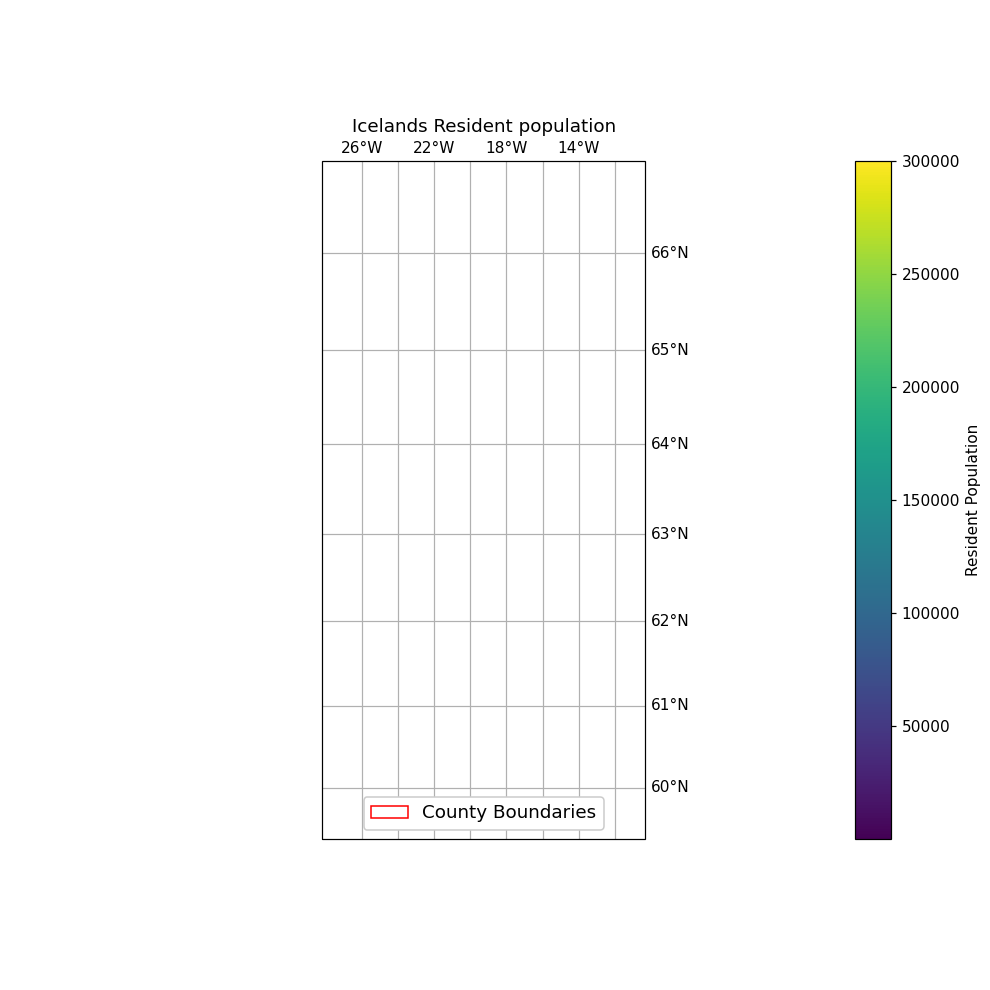

In [20]:
population_plot=population.plot(column='Population', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='r')

population_plot = population.plot(column='Population', ax=ax, vmin=300, vmax=300000, cmap='viridis',
                      legend=True, cax=cax, legend_kwds={'label': 'Resident Population'})

population_outlines = ShapelyFeature(population['geometry'], myCRS, edgecolor='r', facecolor='none')

ax.add_feature(population_outlines)
population_handles = generate_handles([''], ['none'], edge='r')

ax.set(title='Icelands Resident population')
ax.legend(population_handles, ['County Boundaries'], fontsize=12, loc='lower center', framealpha=1)

myFig2

In [ ]:

#----------------------------------------------------------------------------------------